In [1]:
import pandas as pd
from matplotlib import pyplot as plt

def getReceiptMbs():
    df = pd.read_csv("data/75000i.csv",names = ['recpt_id','quantity','item'])
    
    # mbs: market baskets; maps the receipt number to a set of all the items purchased
    mbs = {}
    for row in df.values:
        item_id = row[2]
        r_id = row[0]

        if(r_id not in mbs):
            mbs[r_id] = set()

        mbs[r_id].add(item_id)
    
    return mbs

In [2]:
def getItemSets():
    df = pd.read_csv("data/1000i.csv",names = ['recpt_id','quantity','item'])
    
    return set(df['item'])

In [3]:
# Returns support of itemset
# Checks how many marketbaskets contain the itemset
def getSupport(itemset,mbs):
    count = 0
    for mb in mbs:
        if (itemset.issubset(mb)):
            count+=1
    return count/len(mbs)

In [4]:
"""
mbs: marketbaskets; map of receipt number to market basket
itemset: set of all items
minSup: minimum support number

return:
"""
def apriori(mbs, itemset, minSup):
    F = [] # list of F1, F2, ..., Fn
    F1 = [] # list of all item sets of length 1 where the support of the item set > minSup
    
    for item in itemset:            
        itemSup = getSupport(set([item]), mbs.values())
        if(itemSup >= minSup):
             F1.append(set([item]))
                
    F.append(F1)
    
    k = 1 #index to iterate F, eg. F[0] == F1
    while(len(F[k-1]) > 0):
        Ck = candidateGen(F[k-1], k-1) # candidate frequent itemsets of length k+1
        Fk = []
        
        for candidate in Ck:
            count = 0
            for mb in mbs.values():
                if(candidate.issubset(mb)):
                    count += 1

            if(count/len(mbs) >= minSup):
                Fk.append(candidate)
        
        F.append(Fk)   
        k += 1
                    
    return F

In [5]:
# Passing in arrray of itemsets of length k
# the size/length of the item sets K
# return: set of candidate frequent item sets of length k+1
def candidateGen(Fk, k):
    candidates = set()
    finalCandidates = set()
    
    #generate candidates of length k+1
    for itemset1 in Fk:
        for itemset2 in Fk:
            # check len(set) == k?
            union = itemset1.union(itemset2)
            if( (itemset1 is not itemset2) and (len(union) == len(itemset1) + 1) ):
                candidates.add(frozenset(union))
    
    #prune candidates
    for cand in candidates:
        isValid = True
        for item in cand:
            prunedCand = set([c for c in cand if c != item])
            if (prunedCand not in Fk):
                isValid = False
                continue;
        if (isValid):
            finalCandidates.add(cand)
            
    return finalCandidates 

In [6]:
def maximal(itemsets):
    all_itemsets = []
    maximal = []
    
    for itemset_list in itemsets:
        for itemset in itemset_list:
            all_itemsets.append(set(itemset))
    
    for itemset1 in all_itemsets:
        isMaximal = True
        for itemset2 in all_itemsets:
            if itemset1 is not itemset2 and itemset1.issubset(itemset2):
                isMaximal = False
        if isMaximal:
            maximal.append(itemset1)
    
    return maximal

In [7]:
def genRules(mbs, F, minConf):
    H1 = []
    
    for itemset in F:
        if len(itemset) < 2:
            continue;
        
        for item in itemset:
            conf = getSupport(itemset, mbs.values()) / getSupport(itemset - set([item]), mbs.values())
            if conf >= minConf:
                H1.append([itemset - set([item]), item])
        
    return H1   

In [8]:
def main():
    mbs = getReceiptMbs()
    itemsets = getItemSets()
    frequent_itemsets = apriori(mbs,itemsets, .02)
    maximal_itemsets = maximal(frequent_itemsets)
    maximal_rules = genRules(mbs, maximal_itemsets, .75)
    
    rule_supports = []
    rule_confidences = []
    
    for itemset in maximal_itemsets:
        support = getSupport(itemset, mbs.values())
        print(itemset, " has support: ", support)
    
    # plot confidence vs support
    for rule in maximal_rules:
        itemset = rule[0].union([rule[1]])
        support = getSupport(itemset, mbs.values())
        confidence = getSupport(itemset, mbs.values()) / getSupport((rule[0]), mbs.values())

        rule_supports.append(support)
        rule_confidences.append(confidence)
        #print("rule: ", rule[0], " --> ", rule[1], " has support ", support, " and confidence ", confidence)
        
    plt.plot(rule_supports, rule_confidences)
    plt.xlabel('support')
    plt.ylabel('confidence')
    
    plt.show()

    

{6}  has support:  0.04237333333333333
{8}  has support:  0.04252
{10}  has support:  0.04204
{13}  has support:  0.04236
{20}  has support:  0.04337333333333333
{21}  has support:  0.04324
{25}  has support:  0.041933333333333336
{26}  has support:  0.04238666666666667
{30}  has support:  0.04273333333333333
{34}  has support:  0.04324
{38}  has support:  0.04244
{39}  has support:  0.04409333333333333
{5, 22}  has support:  0.04392
{33, 42}  has support:  0.04306666666666667
{27, 28}  has support:  0.05092
{9, 4}  has support:  0.043146666666666667
{44, 14}  has support:  0.0378
{1, 19}  has support:  0.036853333333333335
{16, 32, 45}  has support:  0.032826666666666664
{49, 7, 15}  has support:  0.0272
{0, 2, 46}  has support:  0.03338666666666667
{17, 29, 47}  has support:  0.02676
{35, 18, 3}  has support:  0.041106666666666666
{48, 36, 12, 31}  has support:  0.020586666666666666
{45, 11, 37, 7}  has support:  0.02792
{23, 40, 41, 43, 24}  has support:  0.020733333333333333


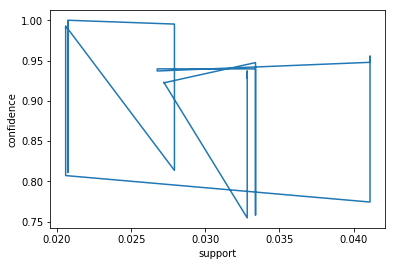

In [9]:
main()